In [20]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from package.RankAMIP.logistic import run_logistic_regression
from package.RankAMIP.data_script import make_BT_design_matrix
from package.RankAMIP.logistic import LogisticAMIP
from package.RankAMIP.logistic import find_closest_matchups
from package.RankAMIP.logistic import isRankingRobust

In [ ]:
### Load in results.
import pickle
with open("results/ChatbotArenaNonrobust.pkl", "rb") as f:
    chatBotArenaDataDropped = pickle.load(f)
with open("results/LLMArenaNonrobust.pkl", "rb") as f:
    LLMArenaDataDropped = pickle.load(f)

### Plots!

#### LLM-as-judge vs. Human-as-judge

In [96]:
### Comparing human vs. llm arena.
###
# normalized number of points dropped for Human vs LLM Arena for top-1, top-5, and top-10
data = {
    'Top-k Ranking': ['Top-1', 'Top-3', 'Top-5', 'Top-10', 'Top-20'],
    'Human Arena': [9 / 39716, 24 / 39716, 5 / 39716, 3 / 39716, 2 / 39716], # data taken from a pickle file produced by chatbotArenaRobustness.ipynb.
    'LLM Arena': [4 / 34297, 15 / 34297, 10 / 34297, 2 / 34297, 2 / 34297] # data taken from a pickle file produced by llmArenaRobustness.ipynb.
}
df = pd.DataFrame(data)
# convert to percentage for plotting
df['Human Arena'] = [x for x in df['Human Arena']]
df['LLM Arena'] = [x  for x in df['LLM Arena']]


In [64]:
27 / 2180

0.012385321100917432

<Figure size 1350x900 with 0 Axes>

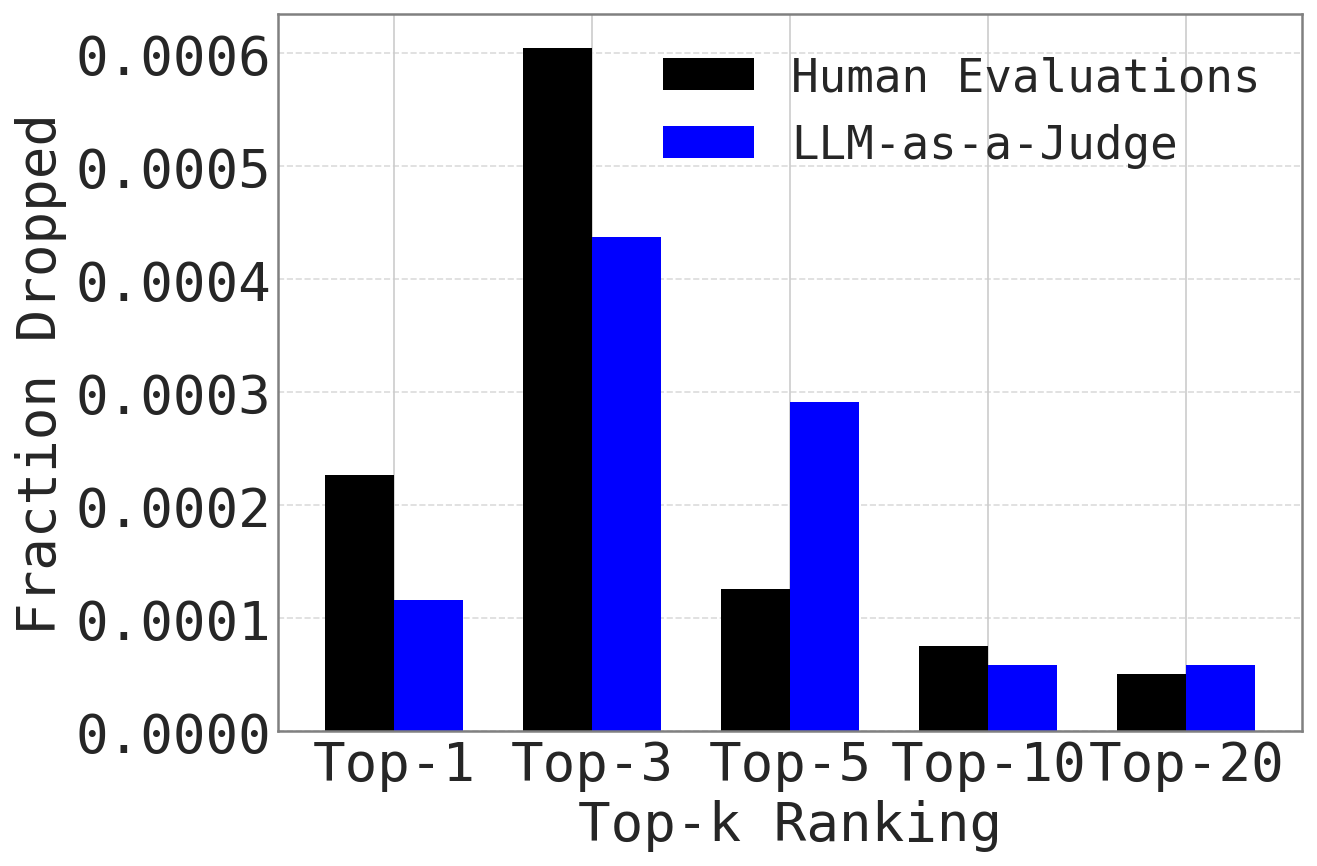

In [ ]:
plt.figure(figsize=(9, 6))
# Set up bar width and positions
bar_width = 0.35
x = np.arange(len(df['Top-k Ranking']))

# Create the plot
plt.figure(figsize=(9, 6))
bars1 = plt.bar(x - bar_width/2, df['Human Arena'], bar_width, label='Human Evaluations', color='black')
bars2 = plt.bar(x + bar_width/2, df['LLM Arena'], bar_width, label='LLM-as-a-Judge', color='blue')

# Labeling
plt.xlabel('Top-k Ranking', fontsize=26)
plt.ylabel('Fraction Dropped', fontsize=26)

# plt.title('Which System is More Robust? Human vs LLM Judge')
plt.xticks(ticks=x, labels=df['Top-k Ranking'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# increase axis sizes.
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.legend(fontsize=22)

plt.tight_layout()
# plt.savefig("fig/human_vs_llm_judge.png", dpi=300)
plt.show()

#### Number of Matches / Difference in Scores

In [ ]:
# Combine human and LLM evaluated data.
nonrobustMatchups = {**chatBotArenaDataDropped, **LLMArenaDataDropped}

# Create the DataFrame
df = pd.DataFrame([
    {
        "matchup": (v[0], v[1]),
        "betaDiff": v[2],
        "numMatchesDropped": len(v[4])
    }
    for k, v in nonrobustMatchups.items()
])
df['dataset'] = ['Human-Judge' if i < 5 else 'LLM-Judge' for i in range(len(df))]

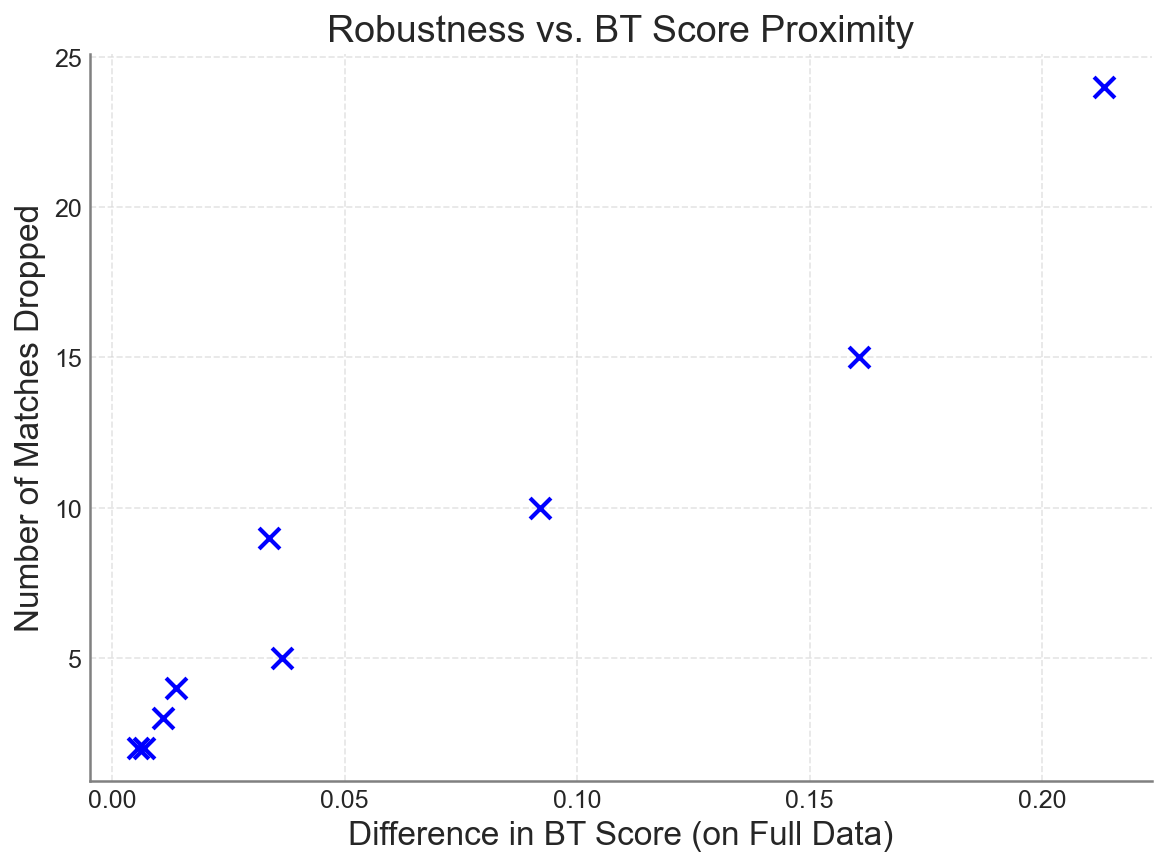

In [ ]:
# Matplotlib styling for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')  # clean grid style
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 150,
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1.2
})

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot: blue crosses with larger size and thicker stroke
ax.scatter(df['betaDiff'], df['numMatchesDropped'], color='blue', marker='x', s=100, linewidths=2)

# Axis labels and title
ax.set_xlabel('Difference in BT Score (on Full Data)')
ax.set_ylabel('Number of Matches Dropped')
ax.set_title('Robustness vs. BT Score Proximity')

# Grid and axis formatting
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optional: add a fitted trend line (commented out)
# z = np.polyfit(df['numMatchesDropped'], df['betaDiff'], 1)
# p = np.poly1d(z)
# ax.plot(df['numMatchesDropped'], p(df['numMatchesDropped']), "r--", label="Trend")

plt.tight_layout()
# plt.savefig("fig/robustness_vs_beta.png", dpi=300, bbox_inches='tight')
plt.show()

Each point represents a pair of models whose relative rankings flipped after dropping a small fraction of matchups. In every case, the flip causes one model to enter the top-k rankings (for some k ∈ {1,3,5,10,20}) while the other is demoted.  These points are taken from both human and LLM-as-a-judge evaluation platforms.

#### Player involvement in dropped matches

<Figure size 2500x2250 with 0 Axes>

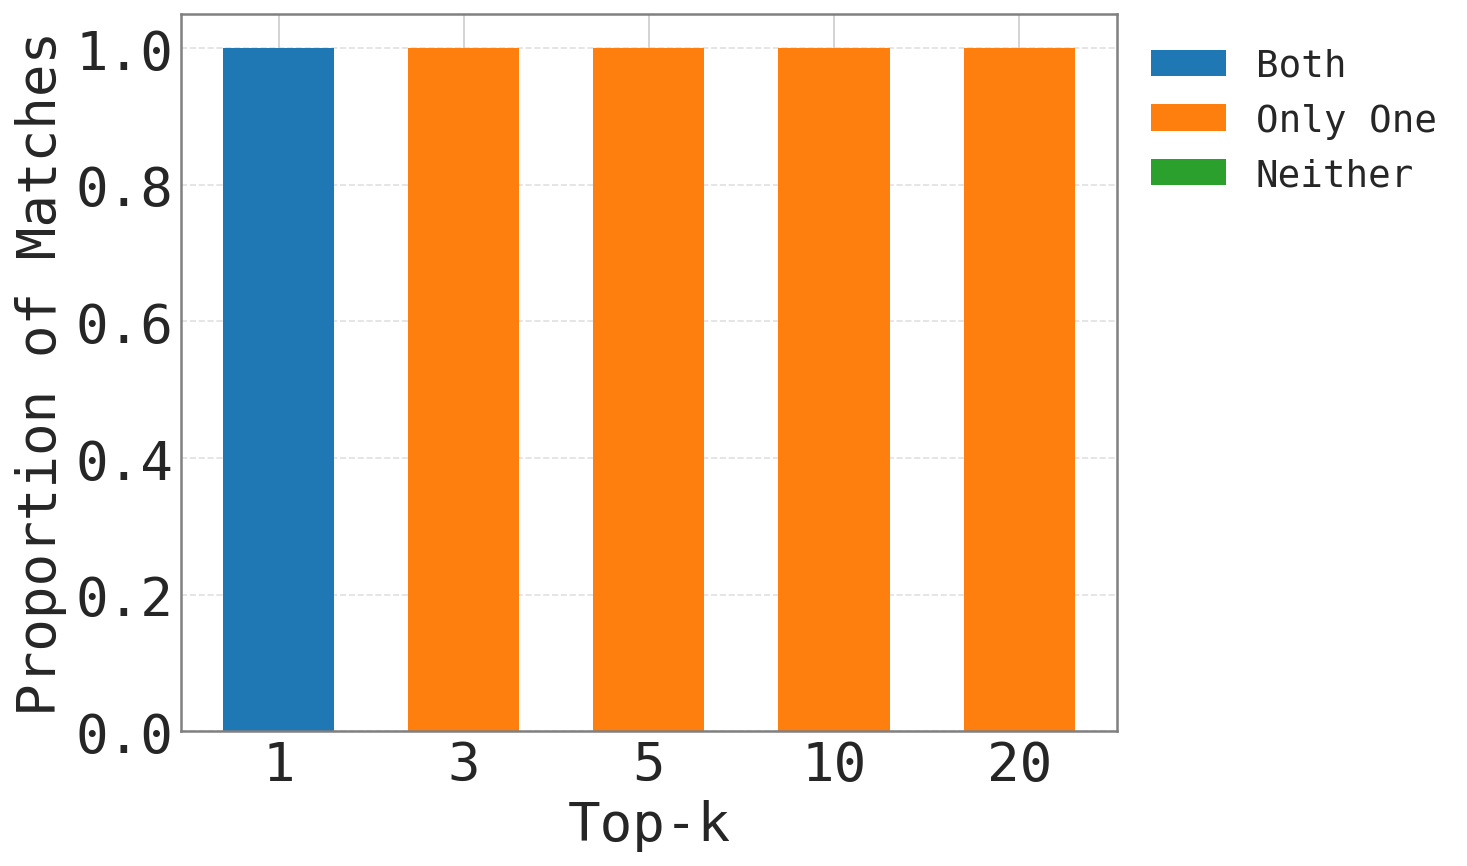

In [94]:
# Plot.
# Set global font to monospace and increase default font size
plt.rcParams.update({
    'font.family': 'monospace',
    'font.size': 14
})

# Plot
plt.figure(figsize=(10, 9), dpi=250)

### Plot Histogram of results.
# See LLMArenaNonrobust.csv and ChatbotArenaNonrobust.csv 
# for the data.
data = {
    "k": [1, 3, 5, 10, 20],
    "prop_both": [1, 0, 0, 0, 0],
    "prop_one": [0, 1, 1, 1, 1],
    "prop_neither": [0, 0, 0, 0, 0]
}

df = pd.DataFrame(data)

# Sort by k just to be safe
df = df.sort_values(by="k")

# Prepare stacked bar segments
bar_labels = df["k"].astype(str)
bar_width = 0.6
x = range(len(df))

fig, ax = plt.subplots(figsize=(10, 6))

p1 = ax.bar(x, df["prop_both"], width=bar_width, label="Both", color="#1f77b4")
p2 = ax.bar(x, df["prop_one"], width=bar_width, bottom=df["prop_both"], label="Only One", color="#ff7f0e")
bottom_sum = df["prop_both"] + df["prop_one"]
p3 = ax.bar(x, df["prop_neither"], width=bar_width, bottom=bottom_sum, label="Neither", color="#2ca02c")

# Labeling
# increase font size
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.set_xticks(x)

ax.set_xticklabels(bar_labels)
ax.set_xlabel("Top-k", fontsize=26)
ax.set_ylabel("Proportion of Matches", fontsize=26)
# ax.set_title("Player Involvement in Dropped Matches")
# place legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
# Save the figure
plt.savefig("fig/player_involvement_llm_arena.png", dpi=300, bbox_inches='tight')
plt.show()

#### Inspect the dropped human evals.

In [138]:
# check the human evals that were dropped to change the top model.
# dropped comparisons: 
# get the rows in df that have these indices.
mis_df = df.iloc[indices][['model_a', 'model_b', 'winner_model_a', 'winner_tie']]
mis_df
# save the df to a csv file.
# mistral_df.to_csv('fig/mistral_df.csv', index=False)


,model_a,model_b,winner_model_a,winner_tie
45535,gpt-4-0125-preview,gpt-4-1106-preview,1,0
13696,gpt-4-0125-preview,gpt-4-1106-preview,1,0
4566,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12544,gpt-4-0125-preview,gpt-4-1106-preview,1,0
35786,gpt-4-0125-preview,gpt-4-1106-preview,1,1
7657,gpt-4-0125-preview,gpt-4-1106-preview,1,0
44022,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12586,gpt-4-0125-preview,gpt-4-1106-preview,1,1
57338,gpt-4-0125-preview,gpt-4-1106-preview,1,0
7386,gpt-4-0125-preview,gpt-4-1106-preview,1,1


In [238]:
# MIS: prompts.
for prompt in df.iloc[indices[:5]]['prompt'].tolist():
    print(prompt)


["Why am I so happy after drinking alcohol? It's like I have forgotten all my problems, and I don't feel anything but happy and calm."]
["what is 1 plus 1"]
["how many lights do I have in my home"]
["Continue this list with plausible social groups, ideology and accusation:\n\nSocial group\tTheory\/ideology\tAccusation\nJews\tZionism\tAntisemitism\nWomen\tFeminism\tSexism\/misogyny\nTrans\tGender identity ideology\tTransphobia\nBlack\tCritical race theory\tRacism\nChinese\tChinese Communist Party\tAnti-Chinese\nVeterans\tJustice of war\tDisrespect of veterans\nSports fans\tValue of sports\tAnti-Australians\nMen\tMale violence\tMisandry\nMuslims\tIslam\tIslamophobia\nMuslims\tHalal\tIslamophobia\nSex workers\tSex market as good\tAnti-sex worker\nAcademics\tLimit population growth\tRacist\/eugenicist\/colonial\nAmericans\tUS foreign policy\tAnti-American\nCatalans\tSeparatism\tCatalanophobia\nLesbians\tSeparatism \tMan-hating\nGay men\tMisogyny\tHomophobia\nWomen\tFemininity \tWoman-hatin

In [239]:
# MIS: response A.
for responseA in df.iloc[indices[:5]]['response_a'].tolist():
    print(responseA)

["Alcohol can make you feel happy and relaxed because it can affect the levels of certain neurotransmitters in your brain, such as dopamine and serotonin. These chemicals are naturally produced in your brain and can contribute to feelings of pleasure and well-being. When you consume alcohol, it can increase the levels of these neurotransmitters, leading to feelings of happiness and relaxation.\n\nHowever, it is important to note that alcohol can also have negative effects on your mental and physical health, and it is not a healthy or sustainable way to cope with problems or stress. If you are relying on alcohol to feel happy or calm, it may be helpful to speak with a mental health professional about healthier ways to manage your emotions and cope with stress."]
["The sum of 1 plus 1 is 2. In mathematical terms, if you have one object or value, and you add another one, the total number of objects or values you have is the sum of the two, which is 2 in this case."]
["I'm just an AI, I do

In [240]:
# MIS: response B.
for responseB in df.iloc[indices[:5]]['response_b'].tolist():
    print(responseB)

["Alcohol is a central nervous system depressant that can have various effects on mood and emotions. When you consume alcohol, it can cause the release of certain chemicals in the brain, such as endorphins and dopamine, which are associated with feelings of happiness and pleasure. Alcohol can also help to decrease anxiety and inhibitions, making you feel more relaxed and calm. However, it's important to note that these effects are temporary, and the negative consequences of alcohol consumption, such as hangovers and long-term health problems, can outweigh the initial pleasurable feelings. Additionally, relying on alcohol as a way to cope with problems or negative emotions can lead to dependence and addiction. If you are concerned about your alcohol consumption or are experiencing negative consequences, it may be helpful to speak with a healthcare professional or substance abuse counselor."]
["The answer to 1 plus 1 is 2."]
["I'm unable to provide an exact answer to that question as I d